In [27]:
%matplotlib inline
import matplotlib
import statistics
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import cohen_kappa_score
from scipy import stats

In [22]:
GROUP = 6
MAX_PART = 14

## Preprocessing

In [23]:
feature_names = ['Ornamentation', 'Grooviness', 'Familiarity', 'Liking', 'Consonance', 'Valence', 'Excitement', 'Vocal Range', 'Sound Quality', 'Tempo', 'Rhythmic Regularity', 'Vocal Tension', 'Vocal Texture']

col_names = ['Participant ID', 'Song ID'] + feature_names

dfs = []

for i in range(GROUP):
    for j in range(MAX_PART):
        filename = '../dataset/evaluation_' + str(i) + chr(65 + j) + '.csv'
        if not Path(filename).is_file():
            continue
        raw_data = pd.read_csv(filename, header=None).to_numpy(dtype=np.float32)[:, 0:len(feature_names) + 1].tolist()
        for row in raw_data:
            row.insert(0, i * 100 + j)
            row[1] = int(row[1])
        dfs.append(pd.DataFrame(raw_data, columns=col_names))

evaluation = pd.concat(dfs).reset_index()
evaluation

,index,Participant ID,Song ID,Ornamentation,Grooviness,Familiarity,Liking,Consonance,Valence,Excitement,Vocal Range,Sound Quality,Tempo,Rhythmic Regularity,Vocal Tension,Vocal Texture
0,0,0,0,100.0,0.0,50.0,50.0,50.0,100.0,50.0,50.0,0.0,50.0,100.0,100.0,50.0
1,1,0,1,100.0,0.0,50.0,50.0,100.0,100.0,0.0,100.0,50.0,100.0,50.0,50.0,0.0
2,2,0,2,0.0,0.0,50.0,50.0,50.0,50.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0
3,3,0,3,100.0,50.0,50.0,50.0,50.0,100.0,50.0,50.0,0.0,100.0,100.0,100.0,50.0
4,4,0,4,0.0,0.0,50.0,0.0,50.0,50.0,100.0,50.0,50.0,50.0,0.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,0,509,25,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,100.0,50.0,50.0,50.0
311,1,509,26,100.0,0.0,50.0,0.0,0.0,50.0,50.0,50.0,0.0,50.0,50.0,100.0,50.0
312,2,509,27,100.0,0.0,50.0,50.0,50.0,50.0,50.0,100.0,50.0,0.0,50.0,50.0,100.0
313,3,509,28,100.0,100.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,100.0,50.0,50.0,100.0


## Intra-method Analysis

In [4]:
matrix = []
for group_id in range(GROUP):
    subset = evaluation[evaluation.apply(lambda x: x['Song ID'] >= group_id * 5 and x['Song ID'] < (group_id + 1) * 5, axis=1)]
    participants = subset.filter(items=['Participant ID'])
    participants = np.unique(participants.to_numpy().flatten())
    for x in participants:
        for y in participants:
            if x < y:
                for feature in feature_names:
                    data_x = subset[subset.apply(lambda t: t['Participant ID'] == x, axis=1)]
                    data_x = data_x.sort_values(by=['Song ID']).filter(items=[feature]).to_numpy().flatten()
                    
                    data_y = subset[subset.apply(lambda t: t['Participant ID'] == y, axis=1)]
                    data_y = data_y.sort_values(by=['Song ID']).filter(items=[feature]).to_numpy().flatten()

                    cohen = cohen_kappa_score(data_x, data_y, [0, 50, 100], weights='quadratic')
                    matrix.append([feature, cohen])

/Users/delton/.local/share/virtualenvs/analysis-98Y6Yy17/lib/python3.7/site-packages/sklearn/metrics/_classification.py:604: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


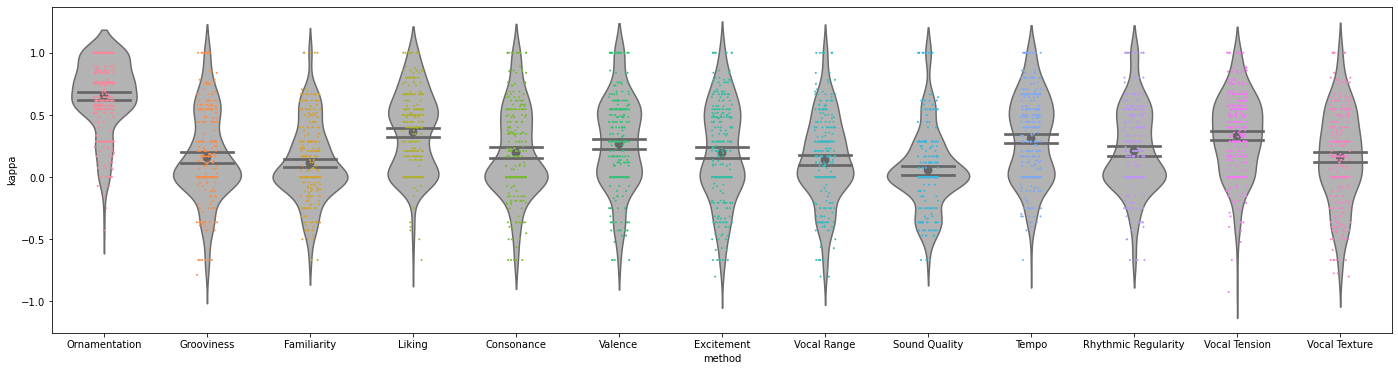

In [5]:
df = pd.DataFrame(matrix, index=range(len(matrix)), columns=['method', 'kappa'])

plt.figure(figsize=(24, 6))

sns.violinplot(x="method", y="kappa", data=df, color="0.7", inner=None)
sns.stripplot(x="method", y="kappa", data=df, jitter=1, size=2)
sns.pointplot(x="method", y="kappa", data=df, ci=95, capsize=.5, join=False, color="#666")

plt.show()

In [6]:
features_filtered = ['Ornamentation', 'Vocal Range', 'Tempo', 'Rhythmic Regularity', 'Vocal Tension', 'Vocal Texture']

matrix = []
for group_id in range(GROUP):
    subset = evaluation[evaluation.apply(lambda x: x['Song ID'] >= group_id * 5 and x['Song ID'] < (group_id + 1) * 5, axis=1)]
    participants = subset.filter(items=['Participant ID'])
    participants = np.unique(participants.to_numpy().flatten())
    for x in participants:
        for y in participants:
            if x < y:
                for feature in features_filtered:
                    data_x = subset[subset.apply(lambda t: t['Participant ID'] == x, axis=1)]
                    data_x = data_x.sort_values(by=['Song ID']).filter(items=[feature]).to_numpy().flatten()
                    
                    data_y = subset[subset.apply(lambda t: t['Participant ID'] == y, axis=1)]
                    data_y = data_y.sort_values(by=['Song ID']).filter(items=[feature]).to_numpy().flatten()

                    cohen = cohen_kappa_score(data_x, data_y, [0, 50, 100], weights='quadratic')
                    matrix.append([feature, cohen])

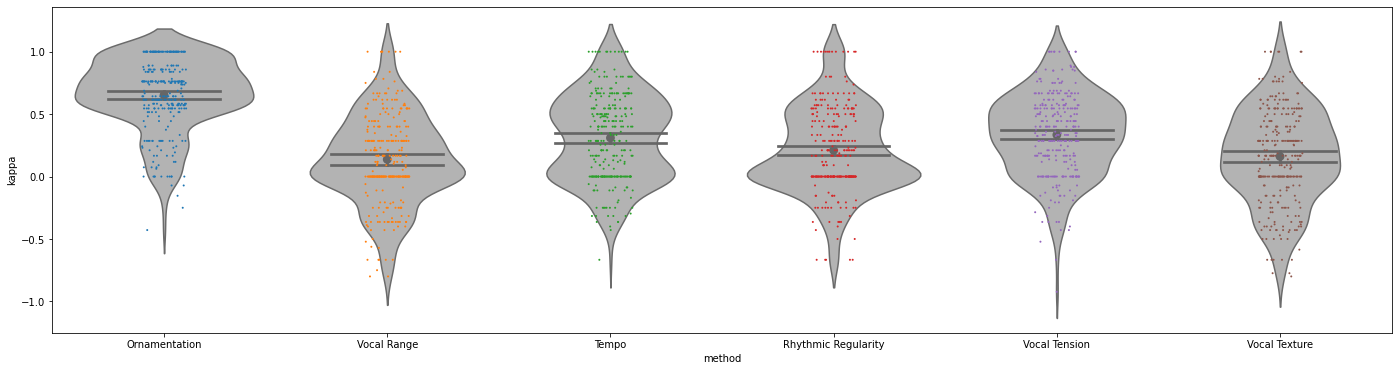

In [7]:
df = pd.DataFrame(matrix, index=range(len(matrix)), columns=['method', 'kappa'])

plt.figure(figsize=(24, 6))
sns.violinplot(x="method", y="kappa", data=df, color="0.7", inner=None)
sns.stripplot(x="method", y="kappa", data=df, jitter=1, size=2)
sns.pointplot(x="method", y="kappa", data=df, ci=95, capsize=.5, join=False, color="#666")

plt.show()

## Inter-method Analysis

In [9]:
matrix_inter = []

In [11]:
total_kappa = 0.0
count_kappa = 0

for group_id in range(GROUP):
    subset = evaluation[evaluation.apply(lambda x: x['Song ID'] >= group_id * 5 and x['Song ID'] < (group_id + 1) * 5, axis=1)]
    participants = subset.filter(items=['Participant ID'])
    participants = np.unique(participants.to_numpy().flatten())
    for x in participants:
        for y in participants:
            if x < y:
                for feature in features_filtered:
                    data_x = subset[subset.apply(lambda t: t['Participant ID'] == x, axis=1)]
                    data_x = data_x.sort_values(by=['Song ID']).filter(items=[feature]).to_numpy().flatten()
                    
                    data_y = subset[subset.apply(lambda t: t['Participant ID'] == y, axis=1)]
                    data_y = data_y.sort_values(by=['Song ID']).filter(items=[feature]).to_numpy().flatten()

                    cohen = cohen_kappa_score(data_x, data_y, [0, 50, 100], weights='quadratic')
                    if not np.isnan(cohen):
                        total_kappa += cohen
                        count_kappa += 1
                        matrix_inter.append(['Yamaha', cohen])

print("Mean Kappa:", total_kappa / count_kappa)

Mean Kappa: 0.30129182502468893


In [10]:
savage_2012_core = [0.36, 0.60, 0.08, 0.35, 0.22, 0.32, 0.32, 0.25, 0.38, 0.20, 0.48, 0.40, 0.37, 0.81, 0.53, 0.68, 0.62, 1.00, 0.25, 0.70, 0.39, 0.51, 0.62, 0.50, 0.64]
for val in savage_2012_core:
    matrix_inter.append(['Savage 2012 (CantoCore)', val])

savage_2012 = [0.36, 0.60, 0.08, 0.35, 0.22, 0.32, 0.32, 0.25, 0.38, 0.20, 0.48, 0.40, 0.37, 0.81, 0.53, 0.68, 0.62, 1.00, 0.25, 0.70, 0.39, 0.51, 0.62, 0.50, 0.64, 0.49, 0.29, 0.19, 0.14, 0.66, 0.31, 0.13, 0.46, 0.20, 0.25, 0.28, 0.15, 0.12, 0.24, 0.42, 0.14, 0.22, 0.07, -0.2, 0.34, 0.16, 0.04]
for val in savage_2012:
    matrix_inter.append(['Savage 2012 (Cantometrics)', val])

savage_2015 = [0.905, 0.870, 0.850, 0.714, 0.441, 0.603, 0.571, 0.500, -0.043, 0.767, 0.426, 0.259, 0.578, 0.585, 0.532, 0.508, 0.260, 0.452, 0.386, 0.172, 0.363, 0.282, 0.189, 0.127, 0.086, -0.017, 0.649]
for val in savage_2015:
    matrix_inter.append(['Savage 2015', val])

In [11]:
mehr_df = pd.read_csv('../thirdparty_data/NHSDiscography_Annotate.csv')

micrometer_duple = []
for _id, row in mehr_df.iterrows():
    if row['micrometer'] == 'Duple' or row['micrometer'] == 'Both duple and triple':
        micrometer_duple.append(1)
    else:
        micrometer_duple.append(0)
mehr_df['micrometer_duple'] = micrometer_duple

micrometer_triple = []
for _id, row in mehr_df.iterrows():
    if row['micrometer'] == 'Triple' or row['micrometer'] == 'Both duple and triple':
        micrometer_triple.append(1)
    else:
        micrometer_triple.append(0)
mehr_df['micrometer_triple'] = micrometer_triple

macrometer_duple = []
for _id, row in mehr_df.iterrows():
    res = row['macrometer_2'] or row['macrometer_4'] or row['macrometer_6'] or row['macrometer_8'] or row['macrometer_10'] or row['macrometer_12'] or row['macrometer_14']
    if row['macrometer_other'] != '.':
        res = res or int(int(row['macrometer_other']) % 2 == 0)
    macrometer_duple.append(res)
mehr_df['macrometer_duple'] = macrometer_duple

macrometer_triple = []
for _id, row in mehr_df.iterrows():
    res = row['macrometer_3'] or row['macrometer_6'] or row['macrometer_9'] or row['macrometer_12'] or row['macrometer_15']
    if row['macrometer_other'] != '.':
        res = res or int(int(row['macrometer_other']) % 3 == 0)
    macrometer_triple.append(res)
mehr_df['macrometer_triple'] = macrometer_triple

variation_melodic = []
for _id, row in mehr_df.iterrows():
    if row['repeat_vary'] == 'Melodic variation' or row['repeat_vary'] == 'hythmic and melodic variation':
        variation_melodic.append(1)
    else:
        variation_melodic.append(0)
mehr_df['variation_melodic'] = variation_melodic

variation_rhythmic = []
for _id, row in mehr_df.iterrows():
    if row['repeat_vary'] == 'Rhythmic variation' or row['repeat_vary'] == 'hythmic and melodic variation':
        variation_rhythmic.append(1)
    else:
        variation_rhythmic.append(0)
mehr_df['variation_rhythmic'] = variation_rhythmic

tension = []
for _id, row in mehr_df.iterrows():
    tension.append(row['tension_melody'] + row['tension_harmony'] + row['tension_rhythm'] + row['tension_motif'] + row['tension_accent'] + row['tension_dynamic'])
mehr_df['tension'] = tension

dynamics = []
for _id, row in mehr_df.iterrows():
    if row['dynamics'] == 'No dynamics':
        dynamics.append(0)
    else:
        dynamics.append(1)
mehr_df['dynamics'] = dynamics

ritard_accel = []
for _id, row in mehr_df.iterrows():
    if row['ritard'] == 'No ritard or accel':
        ritard_accel.append(0)
    else:
        ritard_accel.append(1)
mehr_df['ritard_accel'] = ritard_accel

scale_quality_minor = []
for _id, row in mehr_df.iterrows():
    if row['scale_quality'] == 'Minor':
        scale_quality_minor.append(1)
    elif row['scale_quality'] == 'Unknown':
        scale_quality_minor.append(2)
    else:
        scale_quality_minor.append(0)
mehr_df['scale_quality_minor'] = scale_quality_minor

# Discretization
syncopate = []
for _id, row in mehr_df.iterrows():
    syncopate.append(int(row['syncopate'] * 2))
mehr_df['syncopate'] = syncopate

accent = []
for _id, row in mehr_df.iterrows():
    accent.append(int(row['accent'] * 2))
mehr_df['accent'] = accent

feature_names = ['macrometer_ord', 'syncopate', 'accent', 'dynamics', 'ritard_accel', 'micrometer_duple', 'micrometer_triple', 'macrometer_duple', 'macrometer_triple', 'variation_rhythmic', 'variation_melodic', 'ornament', 'vibrato', 'tension', 'scale_quality_minor']

In [12]:
weighted_features = {}

for feature in feature_names:
    col_size = np.shape(np.unique(mehr_df[feature].to_numpy()))[0]
    if col_size == 2 or feature == 'scale_quality_minor': # scale_quality_minor has multiple values due to our NA processing.
        weighted_features[feature] = False
    else:
        weighted_features[feature] = True

weighted_features

{'macrometer_ord': True,
 'syncopate': True,
 'accent': True,
 'dynamics': False,
 'ritard_accel': False,
 'micrometer_duple': False,
 'micrometer_triple': False,
 'macrometer_duple': False,
 'macrometer_triple': False,
 'variation_rhythmic': False,
 'variation_melodic': False,
 'ornament': False,
 'vibrato': False,
 'tension': True,
 'scale_quality_minor': False}

In [13]:
participants = np.unique(mehr_df['annotator'].to_numpy().flatten())

for x in participants:
    for y in participants:
        if x < y:
            subset = mehr_df[mehr_df.apply(lambda t: t['annotator'] == x or t['annotator'] == y, axis=1)]
            for feature in feature_names:
                data_x = subset[subset.apply(lambda t: t['annotator'] == x, axis=1)]
                data_x = data_x.sort_values(by=['song']).filter(items=[feature]).to_numpy().flatten()
                
                data_y = subset[subset.apply(lambda t: t['annotator'] == y, axis=1)]
                data_y = data_y.sort_values(by=['song']).filter(items=[feature]).to_numpy().flatten()

                if weighted_features[feature]:
                    cohen = cohen_kappa_score(data_x, data_y, weights='quadratic')
                else:
                    cohen = cohen_kappa_score(data_x, data_y)
                matrix_inter.append(['Mehr 2019', cohen])

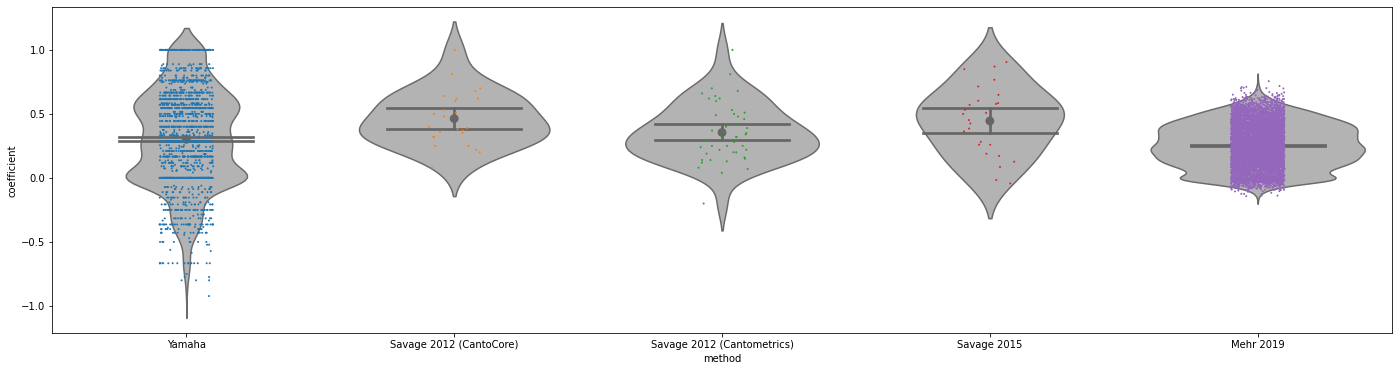

In [14]:
df = pd.DataFrame(matrix_inter, index=range(len(matrix_inter)), columns=['method', 'coefficient'])

plt.figure(figsize=(24, 6))
sns.violinplot(x="method", y="coefficient", data=df, color="0.7", inner=None)
sns.stripplot(x="method", y="coefficient", data=df, jitter=1, size=2)
sns.pointplot(x="method", y="coefficient", data=df, ci=95, capsize=.5, join=False, color="#666")

plt.show()

In [15]:
matrix_yamaha = []
for group_id in range(GROUP):
    subset = evaluation[evaluation.apply(lambda x: x['Song ID'] >= group_id * 5 and x['Song ID'] < (group_id + 1) * 5, axis=1)]
    participants = subset.filter(items=['Participant ID'])
    participants = np.unique(participants.to_numpy().flatten())
    for x in participants:
        for y in participants:
            if x < y:
                for feature in features_filtered:
                    data_x = subset[subset.apply(lambda t: t['Participant ID'] == x, axis=1)]
                    data_x = data_x.sort_values(by=['Song ID']).filter(items=[feature]).to_numpy().flatten()                 
                    data_y = subset[subset.apply(lambda t: t['Participant ID'] == y, axis=1)]
                    data_y = data_y.sort_values(by=['Song ID']).filter(items=[feature]).to_numpy().flatten()

                    cohen = cohen_kappa_score(data_x, data_y, weights='quadratic')
                    matrix_yamaha.append(['Yamaha', cohen])

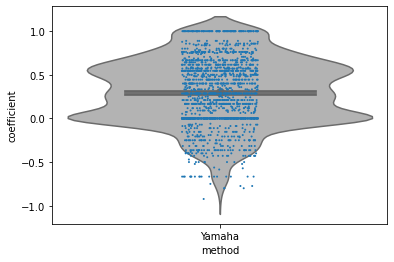

In [16]:
df = pd.DataFrame(matrix_yamaha, index=range(len(matrix_yamaha)), columns=['method', 'coefficient'])

sns.violinplot(x="method", y="coefficient", data=df, color="0.7", inner=None)
sns.stripplot(x="method", y="coefficient", data=df, jitter=1, size=2)
sns.pointplot(x="method", y="coefficient", data=df, ci=95, capsize=.5, join=False, color="#666")

plt.show()

## Reliability

In [24]:
featurewise_kappas = []
features_filtered = ['Ornamentation', 'Vocal Range', 'Tempo', 'Rhythmic Regularity', 'Vocal Tension', 'Vocal Texture']

for group_id in range(GROUP):
    subset = evaluation[evaluation.apply(lambda x: x['Song ID'] >= group_id * 5 and x['Song ID'] < (group_id + 1) * 5, axis=1)]
    participants = subset.filter(items=['Participant ID'])
    participants = np.unique(participants.to_numpy().flatten())
    for x in participants:
        for y in participants:
            if x < y:
                for feature in features_filtered:
                    data_x = subset[subset.apply(lambda t: t['Participant ID'] == x, axis=1)]
                    data_x = data_x.sort_values(by=['Song ID']).filter(items=[feature]).to_numpy().flatten()
                    
                    data_y = subset[subset.apply(lambda t: t['Participant ID'] == y, axis=1)]
                    data_y = data_y.sort_values(by=['Song ID']).filter(items=[feature]).to_numpy().flatten()

                    cohen = cohen_kappa_score(data_x, data_y, [0, 50, 100], weights='quadratic')
                    if not np.isnan(cohen):
                        featurewise_kappas.append(cohen)

print("Mean Kappa:", np.mean(featurewise_kappas))

/Users/delton/.local/share/virtualenvs/analysis-98Y6Yy17/lib/python3.7/site-packages/sklearn/metrics/_classification.py:604: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Mean Kappa: 0.30129182502468854


In [25]:
pairwise_kappas = []

for i in range(GROUP):
    res = list()
    for j in range(MAX_PART):
        filename = '../dataset/pairwise_distance_' + str(i) + chr(65 + j) + '.csv'
        if not Path(filename).is_file():
            continue
        data = np.nan_to_num(pd.read_csv(filename, header=None).to_numpy(), 0)
        # Remove diagonal elements and flattern
        data = data[~np.eye(data.shape[0],dtype=bool)]
        res.append(data)
    
    for x in range(len(res)):
        for y in range(x+1, len(res)):
            cohen = cohen_kappa_score(res[x], res[y], [0, 25, 50, 75, 100], weights='quadratic')
            if not np.isnan(cohen):
                pairwise_kappas.append(cohen)

print("Mean Kappa:", np.mean(pairwise_kappas))

Mean Kappa: 0.29030414275268807


In [26]:
triple_kappas = []

for i in range(GROUP):
    res = list()
    for j in range(MAX_PART):
        filename = '../dataset/triple_distance_' + str(i) + chr(65 + j) + '.csv'
        if not Path(filename).is_file():
            continue
        data = np.nan_to_num(pd.read_csv(filename, header=None).to_numpy(), 0)
        # Remove diagonal elements and flattern
        data = data[~np.eye(data.shape[0],dtype=bool)]
        res.append(data.astype(int))
    
    for x in range(len(res)):
        for y in range(x+1, len(res)):
            cohen = cohen_kappa_score(res[x], res[y], [0, 33, 66, 100], weights='quadratic')
            if not np.isnan(cohen):
                triple_kappas.append(cohen)

print("Mean Kappa:", np.mean(triple_kappas))

Mean Kappa: 0.3499431216931217


In [28]:
stats.f_oneway(featurewise_kappas, pairwise_kappas, triple_kappas)

F_onewayResult(statistic=2.529546010893972, pvalue=0.0799098877660436)